In [1]:
import tensorflow as tf
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from tensorflow import keras
from tensorflow.keras import layers

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
Có 60000 ảnh dùng để train và valid, 10000 ảnh dùng để test
Mỗi ảnh có một kênh màu, kích thước 28x28

Ảnh đầu tiên của tập train
Label đầu tiên của tập train:  5


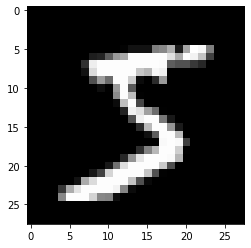

In [2]:

## download MNIST dataset from keras.datasets
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
## rescale images to [0,1]
X_train, X_test = X_train/255.0, X_test/255.0

## dataset information
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print("Có 60000 ảnh dùng để train và valid, 10000 ảnh dùng để test")
print("Mỗi ảnh có một kênh màu, kích thước 28x28")
print()

## Show the first image
print("Ảnh đầu tiên của tập train")
print("Label đầu tiên của tập train: ", y_train[0])
plt.imshow(X_train[0], cmap='gray')
plt.show()

## split data
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1)

In [3]:
class Linear(tf.keras.layers.Layer):
    def __init__(self, units=100):
        super().__init__() 
        self.units = units
    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer=tf.random_normal_initializer,
                                 trainable=True,
                                 name="w1") 
        
        self.b = self.add_weight(shape=(self.units,),
                                 initializer=tf.random_normal_initializer,
                                 trainable=True,
                                 name="b1")
    def call(self, inputs):
        return tf.nn.relu(tf.matmul(inputs, self.w) + self.b)


class ConvMaxpoolBlock(tf.keras.layers.Layer):
    def __init__(self, filter_size, n_filters):
        super().__init__()
        self.filter_size = filter_size
        self.n_filters = n_filters
    def build(self, input_shape):
        self.kernel = self.add_weight(name="kernel",
                                      shape=(self.filter_size[0], self.filter_size[1], input_shape[-1], self.n_filters),
                                      initializer=tf.random_normal_initializer,
                                      trainable=True)
        self.bias = self.add_weight(name="bias",
                                      shape=(1,self.n_filters),
                                      initializer=tf.random_normal_initializer,
                                      trainable=True)
    def call(self, inputs):
        conv = K.conv2d(x=inputs,
                        kernel=self.kernel,
                        padding="same")
        conv = conv+self.bias
        conv = tf.nn.relu(conv)
        maxpool = K.pool2d(conv, 
                           pool_size=(2,2), 
                           strides=(2,2),
                          pool_mode='max')
        return maxpool

class DoubleConvMaxpool(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        
        self.ConvMaxpool1 = ConvMaxpoolBlock(filter_size=[5,5],
                                             n_filters=16)
        self.ConvMaxpool2 = ConvMaxpoolBlock(filter_size=[3,3],
                                             n_filters=32)

    def call(self, inputs):
        out = self.ConvMaxpool1(inputs)
        out = self.ConvMaxpool2(out)
        return out

class DoubleFC(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        self.linear1 = Linear(100)
        self.linear2 = Linear(50)

    def call(self, inputs):
        out = self.linear1(inputs)
        out = self.linear2(out)
        return out

In [4]:
def plot_history(history, nEpoch):
    # Plot loss and accuracy
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(nEpoch)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.tight_layout()
    plt.show()

In [6]:
def get_model():
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(28, 28)))
    model.add(keras.layers.Reshape([28,28,1]))
    model.add(DoubleConvMaxpool())
    model.add(keras.layers.Flatten())
    model.add(DoubleFC())
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

In [7]:
model = get_model()


model.compile(loss = tf.keras.losses.sparse_categorical_crossentropy,
               optimizer= tf.keras.optimizers.Adam(learning_rate=5e-5),
               metrics=['accuracy'])

In [8]:
# input_shape = [None, 28, 28, 1]
# model.build(input_shape=input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
double_conv_maxpool (DoubleC (None, 7, 7, 32)          5056      
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
double_fc (DoubleFC)         (None, 50)                161950    
_________________________________________________________________
dense (Dense)                (None, 10)                510       
Total params: 167,516
Trainable params: 167,516
Non-trainable params: 0
_________________________________________________________________


In [9]:
BATCH_SIZE=512
nEPOCH=30

mc = keras.callbacks.ModelCheckpoint(filepath="epoch: {epoch:02d}.hdf5", 
                                     monitor='val_loss',
                                     mode='min', 
                                     verbose=0,
                                     save_best_only=False)

history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=nEPOCH,
                    validation_data=(X_valid, y_valid),
                    callbacks=[mc])

Epoch 1/30
106/106 [==============================] - 32s 23ms/step - loss: 2.2708 - accuracy: 0.1806 - val_loss: 2.2037 - val_accuracy: 0.3120
Epoch 2/30
106/106 [==============================] - 2s 19ms/step - loss: 1.9516 - accuracy: 0.4689 - val_loss: 1.5472 - val_accuracy: 0.6673
Epoch 3/30
106/106 [==============================] - 2s 19ms/step - loss: 1.0974 - accuracy: 0.7618 - val_loss: 0.7511 - val_accuracy: 0.8213
Epoch 4/30
106/106 [==============================] - 2s 19ms/step - loss: 0.6029 - accuracy: 0.8446 - val_loss: 0.5265 - val_accuracy: 0.8513
Epoch 5/30
106/106 [==============================] - 2s 19ms/step - loss: 0.4660 - accuracy: 0.8686 - val_loss: 0.4446 - val_accuracy: 0.8740
Epoch 6/30
106/106 [==============================] - 2s 19ms/step - loss: 0.4089 - accuracy: 0.8811 - val_loss: 0.4041 - val_accuracy: 0.8825
Epoch 7/30
106/106 [==============================] - 2s 19ms/step - loss: 0.3726 - accuracy: 0.8899 - val_loss: 0.3726 - val_accuracy: 0.889

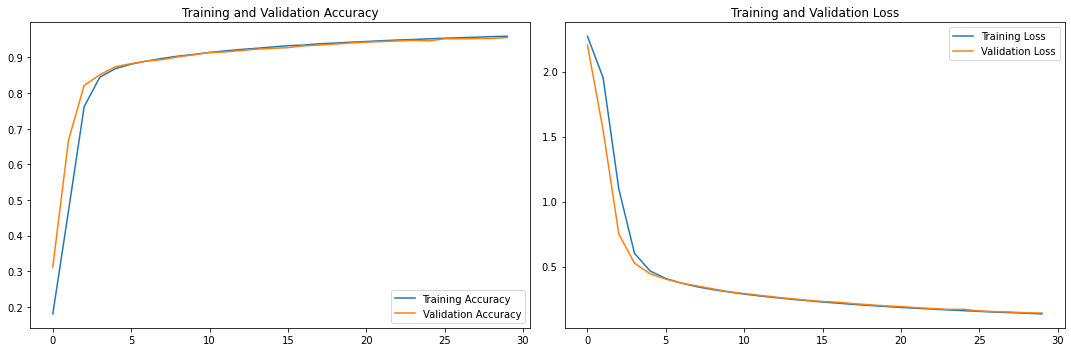

In [10]:
plot_history(history, nEPOCH)